In [2]:
#import bibliothèques

import pandas as pd
import numpy as np
from sklearn import svm, model_selection, preprocessing
from sklearn.model_selection import train_test_split
from joblib import dump, load
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from datetime import datetime
from catboost import CatBoostClassifier


In [3]:
pd.set_option('display.max_columns', None)

data_path = '../../Data'

X_train = pd.read_csv('{0}/X_train.zip'.format(data_path), compression=dict(method='zip', archive_name='X_train.csv'))
X_test = pd.read_csv('{0}/X_test.zip'.format(data_path), compression=dict(method='zip', archive_name='X_test.csv'))
y_train = pd.read_csv('{0}/y_train.zip'.format(data_path), compression=dict(method='zip', archive_name='y_train.csv'))
y_test = pd.read_csv('{0}/y_test.zip'.format(data_path), compression=dict(method='zip', archive_name='y_test.csv'))



Modélisations

In [7]:
model_params = {
    'Régression Logistique': {
        'model': LogisticRegression(solver='liblinear', random_state= 42),
        'params': {
            'C': [1, 5, 10],
            'penalty': ['l1', 'l2'],
        }
    },
    'Decision Tree' : {
        'model' : DecisionTreeClassifier(random_state=42) ,
        'params' : {
            'criterion' : ['gini', 'entropy' ],
            'max_depth' : [1, 3, 5, 10, 20, 30, 50, None]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state = 42),
        'params': {
            'min_samples_split': list(range(2, 21, 2)),  # Nombre aléatoire entre 2 et 21
            'n_estimators': [5, 10, 15], 
            'max_depth': [5, 10, None]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state = 42, algorithm = 'SAMME'),
        'params': {
            'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
            'n_estimators': [10, 50, 100, 500]
        }
    },
    'GradientBoosting' : {
        'model' : GradientBoostingClassifier(),
        'params' : {
            'loss' : ['log_loss'],
            #'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
            'learning_rate': [0.01, 0.05, 0.1, 0.2],
            #'min_samples_split': np.linspace(0.1, 0.5, 12),
            #'min_samples_leaf': np.linspace(0.1, 0.5, 12),
            'max_depth':[3,5,8],
            'max_features':['log2','sqrt'],
            'criterion': ['friedman_mse', 'mae'],
            #'subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
            'subsample':[0.5,  0.8,  0.9, 1.0],
            'n_estimators':[10,50,100,200,300]
        }
    },
    'KNN' : {
        'model' : KNeighborsClassifier(n_jobs=-1),
        'params' : {
            'n_neighbors' : [5,10,20]
        }
    },
    'CatBoost' :{
        'model' : CatBoostClassifier(),
        'params' :{
            'iterations': [500],
            'depth': [4, 5, 6],
            'loss_function': ['Logloss', 'CrossEntropy'],
            'l2_leaf_reg': np.logspace(-20, -19, 3),
            'leaf_estimation_iterations': [10],
#           'eval_metric': ['Accuracy'],
#           'use_best_model': ['True'],
            'logging_level':['Silent'],
            'random_seed': [42]
         }
    }
    
}

best_fitted_models = {}
df_models = pd.DataFrame()


for model_name, params in model_params.items():

    print(datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
    print('modélisation ', model_name)
    clf = GridSearchCV(params['model'], params['params'], scoring='recall_weighted', refit=True, n_jobs = -1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # recupération de la métrique recall
    report =classification_report_imbalanced(y_test, y_pred,output_dict=True)
    df_recall = pd.DataFrame.from_dict(report).transpose()
    
    # Suppression des lignes accuracy,avg_ et total_support
    df_recall = df_recall[~df_recall.index.str.contains('accuracy|avg|total_support')]
    
    # Ne garder que la colonne 'recall'
    df_recall = df_recall[['rec']]
    
    df_recall= df_recall.rename(columns={'rec':model_name})

    df_model = pd.concat([df_model, df_recall.transpose()])

    # sauvegarde des données relatives au meilleurs modèle
    best_fitted_models[model_name] = {}
    
    best_fitted_models[model_name]['estimator'] = clf.best_estimator_
    best_fitted_models[model_name]['best_score'] = clf.best_score_
    best_fitted_models[model_name]['params'] = clf.best_params_
    best_fitted_models[model_name]['recall'] = clf.score(X_test, y_test)
    best_fitted_models[model_name]['classification_report'] = classification_report_imbalanced(y_test, clf.predict(X_test))

    best_fitted_models[model_name]['confusion_matrix'] = pd.crosstab(y_test, y_pred, rownames=['Gravité'], colnames=['Prédiction'])
    best_fitted_models[model_name]['confusion_matrix_norm'] = pd.crosstab(y_test, y_pred, rownames=['Gravité'], colnames=['Prédiction'], normalize='index')

    dump(clf.best_estimator_, './modèles/best_'+model_name+'.joblib')
    
    

for m in best_fitted_models :
    print('###############################')
    print(m)
    print()
    print(f"Meilleur score: {best_fitted_models[m]['best_score']}")
    print(f"Meilleurs paramètres: {best_fitted_models[m]['params']}")
    print(f"Recall : ", {best_fitted_models[m]['recall']})
    print()
    print('Classification Report')
    print(best_fitted_models[m]['classification_report'])
    print()
    print('Matrice de confusion')
    print(best_fitted_models[m]['confusion_matrix'])
    print()
    print('Matrice de confusion normalisée')
    print(best_fitted_models[m]['confusion_matrix_norm'])

display(df_models)

23/10/2024 07:53:25
modélisation  Regression Logisitique
23/10/2024 07:55:02
modélisation  Decision Tree
23/10/2024 07:55:41
modélisation  Random Forest Classifier
23/10/2024 07:58:45
modélisation  Ada Boost Classifier
23/10/2024 08:09:58
modélisation  GradientBoosting


d:\GIT\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
480 fits failed out of a total of 960.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
480 fits failed with the following error:
Traceback (most recent call last):
  File "d:\GIT\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\GIT\.venv\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "d:\GIT\.venv\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "d:\GIT\.venv\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate

23/10/2024 08:16:15
modélisation  KNN
###############################
Regression Logisitique

Meilleur score: 0.5680954025165922
Meilleurs paramètres: {'C': 1, 'penalty': 'l1'}
Recall :  {0.5919885324725163}

Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          0       0.73      0.79      0.79      0.76      0.79      0.62     36623
          1       0.70      0.47      0.86      0.56      0.64      0.39     35764
          2       0.40      0.37      0.90      0.38      0.58      0.31     13794
          3       0.13      0.64      0.88      0.22      0.75      0.55      2417

avg / total       0.65      0.59      0.84      0.61      0.69      0.48     88598


Matrice de confusion
Prédiction      0      1     2     3
Gravité                             
0           28918   4161  1545  1999
1            9436  16877  5639  3812
2            1293   2787  5100  4614
3             152    217   494  1554

Matrice de confusion no

In [8]:
#import shap

d:\GIT\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
#best_fitted_models['Regression Logisitique']['estimator']

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear')

In [10]:
#explainer = shap.Explainer(best_fitted_models['Regression Logisitique']['estimator'].predict, X_test)
#shap_values = explainer.shap_values(X_test)

In [11]:
#shap_values = explainer(X_test)

PermutationExplainer explainer: 88599it [1:14:11, 19.87it/s]                           


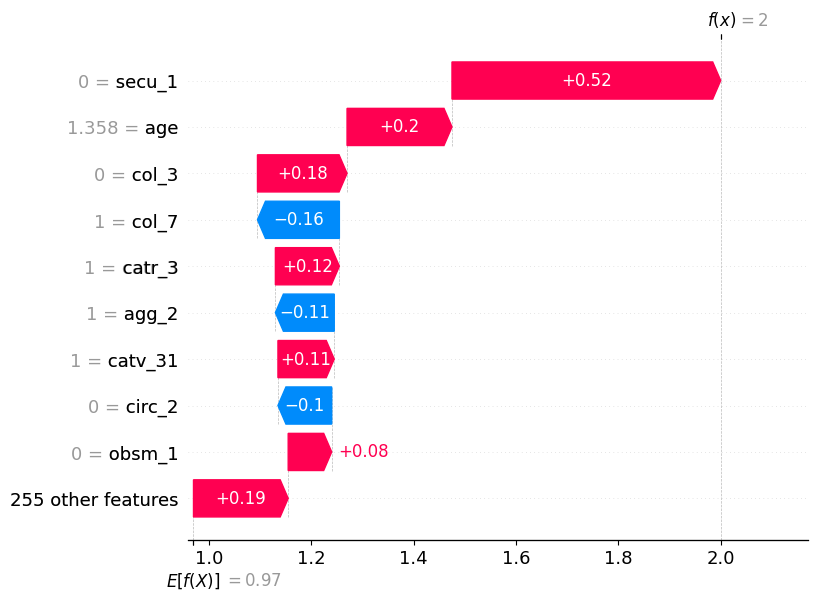

In [12]:
#import matplotlib.pyplot as plt
#shap.plots.waterfall(shap_values[0])


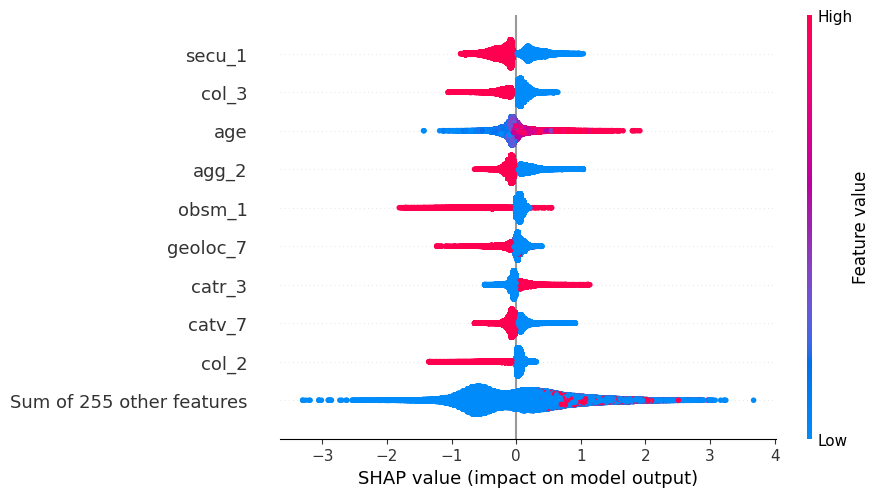

In [15]:
#shap.plots.beeswarm(shap_values)